# Learning the Wave Equation

See the library `nn_1d_pde` for more on this problem.

In [105]:
import numpy as np
import seaborn
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
import sympy

In [530]:
import utils
import plotting
import helper
import analytical_solutions
import models
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)
importlib.reload(analytical_solutions)
from helper import *
from utils import *
from analytical_solutions import *

In [534]:
ts, data = make_wave_dataset(10, 500, t_max=83,
                             params=WAVE_PARAMS[1])
torch_data = data_to_torch(data, device=device)
NT,_,NX = data.shape
dt = ts[1]-ts[0]
data.shape

[0.19350920659919693, -0.024188650824899606, 0.007167007651822101, -0.0030235813531124464, 0.0015480736527935708, -0.0008958759564777596, 0.0005641667830880341, -0.00037794766913905347, 0.00026544472784526056, -0.00019350920659919448, 0.00014538633102868976, -0.00011198449455971839, 8.807883777842609e-05, -7.052084788600294e-05, 5.733606121457203e-05, -4.724345864238052e-05, 3.9387178220883785e-05, -3.318059098065654e-05, 2.8212451756695488e-05, -2.418865082489838e-05]


(500, 2, 10)

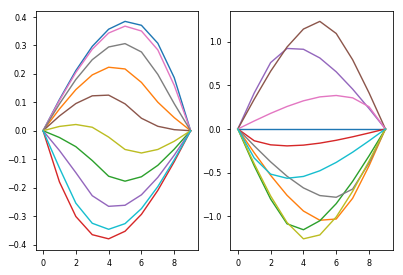

In [535]:
plt.subplot(1,2,1)
for i in range(0,NT,NT//10):
    plt.plot(data[i,0,:])
plt.subplot(1,2,2)
for i in range(0,NT,NT//10):
    plt.plot(data[i,1,:])

(100, 200)

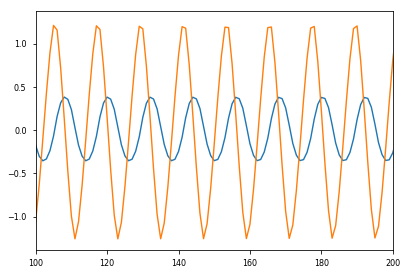

In [536]:
plt.plot(data[:,0,NX//2])
plt.plot(data[:,1,NX//2])
plt.xlim(100,200)

In [462]:
device=get_device()
set_seed()

Using the CPU


In [464]:
import functools

In [465]:
class MultiLinear(torch.nn.Module):
    """Like Linear, but allows for higher ranks."""
    def __init__(self, in_dims, out_dims, bias=True):
        super(MultiLinear, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        in_features = functools.reduce(lambda x,y:x*y, in_dims)
        out_features = functools.reduce(lambda x,y:x*y, out_dims)
        self.net = torch.nn.Linear(in_features, out_features, bias=bias)
    def forward(self, x):
        xflat = torch.flatten(x, start_dim=-len(self.in_dims))
        hflat = self.net(xflat)
        return torch.reshape( hflat, hflat.shape[:-1]+self.out_dims )

In [537]:
model = models.MultiLinear((2,NX),(2,NX),bias=False).double()

Using the CPU


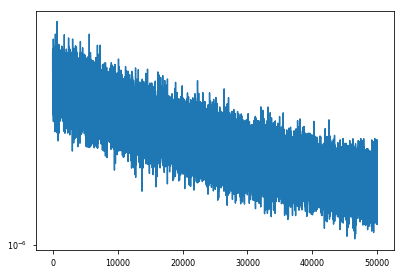

In [548]:
_,losses=learn_rnn(torch_data, model, N_iter=50000,
                   batch_size=200,learning_rate=1.0e-4)
plt.semilogy(losses)

In [549]:
UV = integrate_model(model, torch_data[0:1,:,:],nsteps=25)

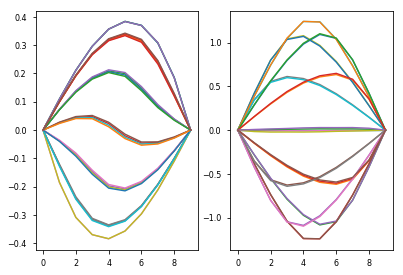

In [550]:
plt.subplot(1,2,1)
for i in range(UV.shape[0]):
    plt.plot(UV[i,0,:])
plt.subplot(1,2,2)
for i in range(UV.shape[0]):
    plt.plot(UV[i,1,:])

In [551]:
Omega = model.net.weight.detach().cpu().numpy()
w,V = np.linalg.eig(Omega)
#Lambda = V.dot( np.diag(np.log(w)/dt).dot(np.linalg.inv(V)))
Lambda = V @ np.diag(np.log(w)/dt) @ np.linalg.inv(V)
Lambda = np.array(Lambda,dtype=np.double)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


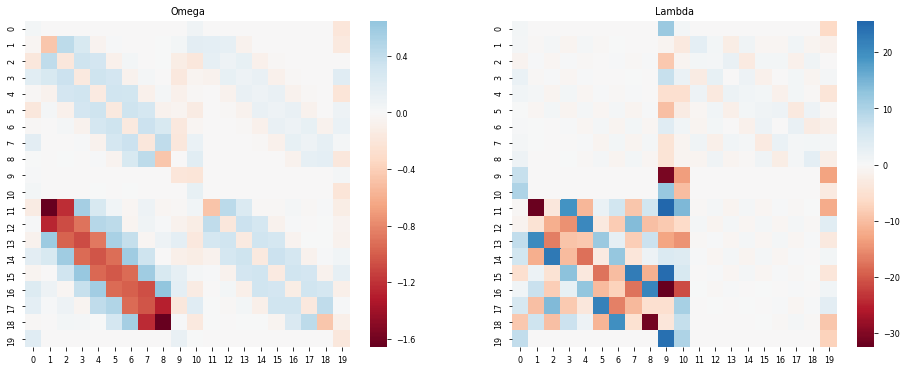

In [552]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.subplot(1,2,1)
plt.title('Omega')
seaborn.heatmap(Omega, cmap='RdBu', center=0)
plt.subplot(1,2,2)
plt.title('Lambda')
seaborn.heatmap(Lambda, cmap='RdBu', center=0)